# Model project: Solow with natural ressources

In [1]:
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm
import scipy as sc
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
sm.init_printing(use_unicode=True)

The model considered in this project is a Solow model with a fixed natural ressource, X, which could be interpreted as land. The aim of the project is to describe the effect of the amount of land on the economy through numerical simulation of the model and visualizations. We illustrate the positive effects of savings and technological growth as well as the negative effect of population growth on the economy. Finally, we illustrate the diminishing returns to scale on land in the economy. 

## The baseline model

(1) $ \quad Y_t = K_t^{\alpha} (A_tL_t)^{\beta} X^{\kappa} $

(2) $\quad K_{t+1} - K_t = s_K Y_t - \delta K_t $

(3) $\quad L_{t+1} = (1+n)L_t$

(4) $\quad A_{t+1} = (1+g)A_t$

We define $z_t$ as the capital/output ratio, $k_t/y_t$. By combining the model equations we can derive the transition equation for z which will be used for solving the model. 

(5) $\quad z_{t+1} = (\frac{1}{(1+n)(1+g)} )^{\beta} (s + (1-\delta)z_t )^{1-\alpha} z_t^{\alpha}    $

(6) $\quad  y^* = (z^*)^{\frac{\alpha}{\beta + \kappa}} A_0^{\frac{\beta}{\beta + \kappa}} \big( \frac{X}{L_0} \big)^{\frac{\kappa}{\beta + \kappa}} (1+g)^{\frac{\beta}{\beta + \kappa}} (1+n)^{-\frac{\alpha}{\beta + \kappa}} $

# Solving the model 

## The algorithm

The model is solved by numerically finding the steady state, defined as the point where $z_t = z_{t+1}$. We use equation (5) and construct a root-finding problem by subtracting $z_t$ from both sides: 
$$ z^* = z_t = z_{t+1} \Leftrightarrow z_t - (\frac{1}{(1+n)(1+g)} )^{\beta} (s + (1-\delta)z_t )^{1-\alpha} z_t^{\alpha} = 0 $$ 
The root-finding problem is solved using scipys optimization function, in which we use the Brent-method. The Brent-method combines the bisection and the secant method making it a more robust and effective method than any of the two used seperately. It uses the secant method first, but turns to the bisectio method if  The secant method has a superlinear rate of convergence, but it does not have global convergence (can not always find a root). The bisection method does have global convergence, but only has a linear rate of convergence. Thus, by combing the two, we get a method which is faster than the bisection method, and more robust than the secant method. 

## Numerical solution

### The effect of savings, technological growth and population growth. 

To calculate the value of the capital/output ratio steady state $z^*$ numerically, we define the optimization function and the parameter values below. The optimization function is used to simulate the model, and the simulations are used to create an interactive plot of the steady state value of $z^*$. (Click dots below to view code for simulation and plotting.)

In [2]:
#Define the parameters. 
T = 200
k0 = 0.1
x = 100
A = 100
s = 0.2
g = 0.05
n = 0.05
alpha = 1/3
beta = 1/3
kappa = 1 - alpha - beta
delta = 0.05

In [3]:
def get_steadystate(s,g,n,alpha,beta,kappa,delta):
    ### Function that finds the numerical steady state value for z by using Brent's method. 
    obj_z = lambda z: z - (1/((1+n)*(1+g)))**beta *(s+(1-delta)*z)**(1-alpha)*z**alpha

    result = sc.optimize.root_scalar(obj_z,bracket=[0.1,100],method='brentq')
    return result.root

def solow_eq(z,x,A,alpha,beta,kappa,delta,s,n,g):
    
    ### Calculate z_t+1 given value of z_t, as defined by equation (XX) 
    z_plus = (1/((1+n)*(1+g)))**beta *(s+(1-delta)*z)**(1-alpha)*z**alpha   

    return z_plus

def simulate_solow_model(k0,x,A,alpha,beta,kappa,delta,s,n,g,T):
    ### Function that simulates the model by looping through all t from 1 to T. 
    ### Returns a list holding the growth path for z. 
    
    # a. initialize
    #k_path = [k0]
    z0 = k0**(1-alpha) * A**(-beta) * x**(-kappa) 
    z_path = [z0]
    
    # b. simulate forward
    for t in range(1,T):
        
        # i. apply solow equation
        z_plus = solow_eq(t,x,A,alpha,beta,kappa,delta,s,n,g) 
                
        # ii. save result
        z_path.append(z_plus)
        
    return z_path

In [4]:
def _plot_zgrowth(k0,x,A,alpha,beta,kappa,delta,s,n,g,T):

    z_path = simulate_solow_model(k0,x,A,alpha,beta,kappa,delta,s,n,g,T) 
    deg = np.linspace(0,0+T,T) 
    
    #Create figure
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(z_path, label = 'Growth path for z')
    ax.plot(deg,lw=2,label='45 degree') 

    # Calculate and insert st.st. indicator
    stst = get_steadystate(s,g,n,alpha,beta,kappa,delta)
    ax.scatter(stst,stst,s=20, marker = 'o', c='green', label= 'steady state')
    ax.text(stst + 0.2, stst, f'steady state for z = {stst:6.5f}', horizontalalignment='left', size='medium', color='black')

    # Format
    ax.set_title('Growth path and steady state for the capital/output ratio, $z_t$')
    ax.legend(loc='upper left')
    ax.set_xlim([0,10])
    ax.set_xlabel('$z_t$')
    ax.set_ylabel('$z_{t+1}$')
    ax.set_ylim([0,10])
    ax.grid(True)
    plt.show()

In [5]:
interact(_plot_zgrowth
         ,k0=fixed(k0)
         ,x=fixed(x)
         ,A=fixed(A)
         ,alpha=fixed(alpha)#widgets.FloatSlider(description="alpha", min=0.05,max=1-alpha-kappa,step=0.05,value=0.3)
         ,beta=fixed(beta) #widgets.FloatSlider(description="beta", min=0.05,max=1-alpha-kappa,step=0.05,value=0.3)
         ,kappa=fixed(kappa) #widgets.FloatSlider(description="kappa", min=0.05,max=1-beta-alpha,step=0.05,value=0.3)
         ,delta=fixed(delta)
         ,s=widgets.FloatSlider(description="Savings, s", min=0.05,max=0.99,step=0.05,value=0.2)
         ,n=widgets.FloatSlider(description="Pop. growth, n", min=-0.3,max=1,step=0.001,value=0.05)
         ,g=widgets.FloatSlider(description="TFP growth, g", min=0,max=0.96,step=0.05,value=0.3)
         ,T=fixed(T));

interactive(children=(FloatSlider(value=0.2, description='Savings, s', max=0.99, min=0.05, step=0.05), FloatSl…

Main (and well-known) takeaways from the interactive diagram of the numerically solved steady state value for the capital / output ratio: 
 - Higher savings yield higher steady state of the capital output ratio. 
 - There is a negative effect from higher population growth on the steady state capital output ratio. 
 - The negative effect from a higher n can be made up for by a higher technological growth rate, g. 
 


### The effect of the fixed amount of land per capita on income per capita 

To examine the effect of land on the economy, we turn to the steady state level of income per capita, which is given by equation (6). As we see from the equation, the income per capita depends positively on the steady state capital/output ratio and on the fixed amount of land, X, that the country has. The positive relationship is illustrated in the plot below. 

In [6]:
def y(x):
    ### Function that evaluates the equation for y* given above. 
    
    #Define parameter values (set to plausible) (Defining X/L as x)
    s = 0.2
    alpha = 1/3
    beta = 1/3
    kappa = 1/3
    delta = 0.05
    n = 0.02
    g = 0.05
    A = 100
    
    #Find z^*
    z = get_steadystate(s,g,n,alpha,beta,kappa,delta)
    
    #Calculate y 
    y = z**(alpha/(beta+kappa)) * A**(beta/(beta+kappa)) * x**(kappa/(beta+kappa)) * (1+g)**(beta/(beta+kappa)) * (1+n)**(-kappa/(beta+kappa))
    
    return y

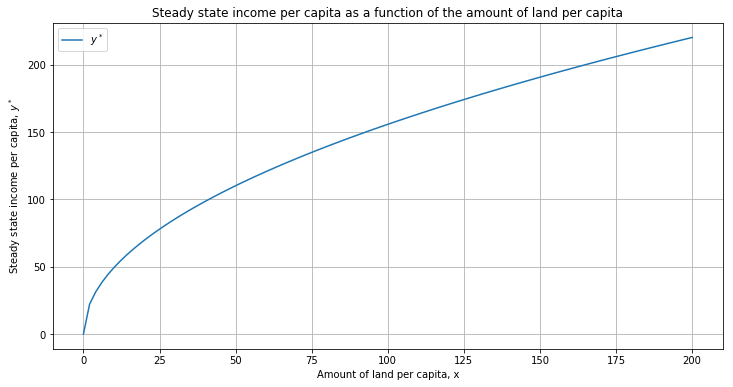

In [7]:
# Define an array of x's and apply y function to x
x = np.linspace(0,200,100) 
y_star = y(x)

#Create figure
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(x,y_star, label='$y^*$')
ax.set_title('Steady state income per capita as a function of the amount of land per capita')
ax.legend(loc='upper left')
ax.set_xlabel('Amount of land per capita, x')
ax.set_ylabel('Steady state income per capita, $y^*$')
ax.grid(True)

The plot above shows the positive relationship between the amount of land and the steady state income, ceteris paribus. The graph displays as well the diminishing returns to scale on land through the stalling effect on the steady state income per capita as land gets bigger and bigger. 

## Sources

- The model considered in this project as well as the intuition behind it is taken from Sørensen and Whitta, Introducing Advanced Macroeconomics, chapter 7.  
- For this project we have used snippets from the NumEcon Snippets-2019 github repository (https://github.com/NumEconCopenhagen/snippets-2019 ). (Solow snippet for model simulation and Expenditure minimization snippet for the interactive graph.) 